In [1]:
# Data manipulation
# ==============================================================================
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset


# Plots
# ==============================================================================
import matplotlib.pyplot as plt
#from skforecast.plot import set_dark_theme

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    backtesting_forecaster_multiseries,
    grid_search_forecaster_multiseries
)

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# check linraries versions
import importlib, sys
print("Python:", sys.version)
for pkg in ["skforecast", "lightgbm", "sklearn", "pandas", "numpy"]:
    try:
        m = importlib.import_module(pkg)
        print(f"{pkg}:", getattr(m, "__version__", "OK"))
    except Exception as e:
        print(f"{pkg}: NOT FOUND -> {e}")


Python: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
skforecast: 0.17.0
lightgbm: 4.6.0
sklearn: 1.7.1
pandas: 2.3.1
numpy: 2.2.1


c:\Users\maria.diazalba\OneDrive - Cordis US Corp\0 MARIA\SKU Demand\venv_psr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


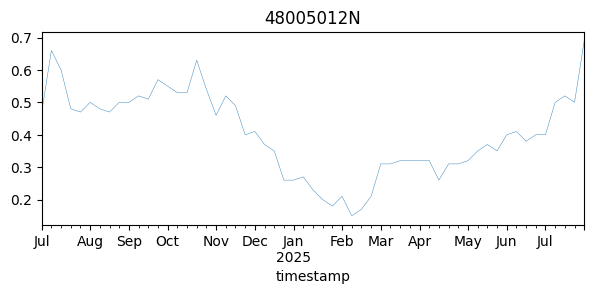

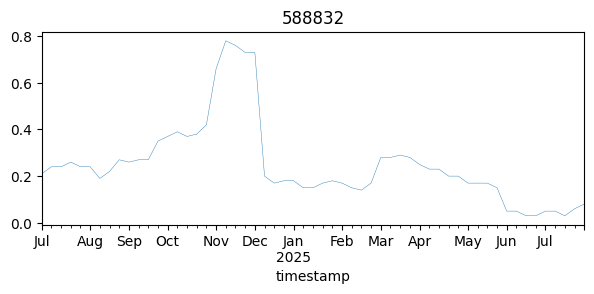

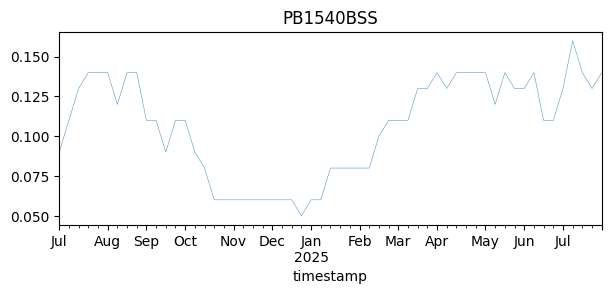

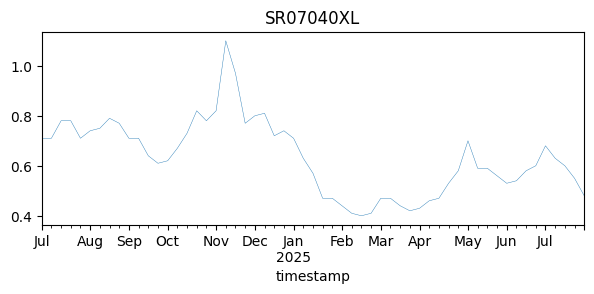

{'12000210': timestamp
2024-07-03    1.177311
2024-07-10    0.871362
2024-07-17    0.718387
2024-07-24    0.718387
2024-07-31    0.718387
2024-08-07    0.718387
2024-08-14    0.718387
2024-08-21    0.565413
2024-08-28    0.718387
2024-09-04    0.565413
2024-09-11    0.565413
2024-09-18    0.565413
2024-09-25    0.565413
2024-10-02    2.091132
2024-10-09    2.091132
2024-10-16    1.177311
2024-10-23    1.024336
2024-10-30    0.871362
2024-11-06    1.177311
2024-11-13    1.024336
2024-11-20    1.024336
2024-11-27    0.871362
2024-12-04    0.871362
2024-12-11    0.718387
2024-12-18   -0.348408
2024-12-25   -0.348408
2025-01-01   -1.109255
2025-01-08   -1.109255
2025-01-15   -1.262229
2025-01-22   -1.262229
2025-01-29   -1.262229
2025-02-05   -1.109255
2025-02-12   -1.415204
2025-02-19   -1.415204
2025-02-26   -1.415204
2025-03-05   -1.874127
2025-03-12   -1.262229
2025-03-19   -1.262229
2025-03-26   -0.956280
2025-04-02   -1.568178
2025-04-09   -1.568178
2025-04-16   -0.501382
2025-04-23 

In [ ]:
### GET DATA
df_complete = pd.read_excel("./results/df_features.xlsx")
df = df_complete[['SKU','week','ADD','sin_week','cos_week','week_number']].copy()
df = df.rename(columns={"SKU": "series_id", 'week': "timestamp"})


### PREPARE DATA FOR MODELING
series = df[['series_id','timestamp','ADD']].copy()  
exog = df[['series_id','timestamp','sin_week','cos_week','week_number']].copy()  

series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])

all_skus = series["series_id"].unique()
skus_to_plot = np.random.choice(all_skus, size=min(4, len(all_skus)), replace=False)

for sku in skus_to_plot:
    fig, ax = plt.subplots(1, 1, figsize=(7, 2.5))
    df.query('series_id == @sku').plot(
        x='timestamp',
        y=['ADD'],
        ax=ax,
        title=sku,
        linewidth=0.3,
        legend=False,
    )
    plt.show()



### Split Train/Test by date (test = last 4 weeks)
last_date  = series['timestamp'].max()
end_train  = (last_date - pd.Timedelta(weeks=4))
start_test = end_train + pd.Timedelta(weeks=1)

series_train = series.loc[series['timestamp'] <= end_train].copy()
series_test  = series.loc[series['timestamp'] >= start_test].copy()

exog_train   = exog.loc[exog['timestamp'] <= end_train].copy()
exog_test    = exog.loc[exog['timestamp'] >= start_test].copy()


### Normalization Z-score using only train data (mu & sigma)

stats_train = (
    series_train
    .groupby('series_id')['ADD']
    .agg(mu='mean', sigma=lambda x: x.std(ddof=0))
    .reset_index()
)
stats_train['sigma'] = stats_train['sigma'].replace(0.0, 1.0)

series_train = series_train.merge(stats_train[['series_id', 'mu', 'sigma']],
                                  on='series_id', how='left')
series_test  = series_test.merge(stats_train[['series_id', 'mu', 'sigma']],
                                 on='series_id', how='left')
series_train['z_ADD'] = (series_train['ADD'] - series_train['mu']) / series_train['sigma']
series_test['z_ADD']  = (series_test['ADD']  - series_test['mu'])  / series_test['sigma']


### Dictionaries for skforest
series_train = series_train.sort_values(['series_id', 'timestamp'])
series_test = series_test.sort_values(['series_id', 'timestamp'])

series_dict_train = {
    sku: df.set_index('timestamp')['z_ADD'].sort_index().asfreq('W-WED')
    for sku, df in series_train.groupby('series_id', sort=False)
}

series_dict_test = {
    sku: df.set_index('timestamp')['z_ADD'].sort_index().asfreq('W-WED')
    for sku, df in series_test.groupby('series_id', sort=False)
}

exog_train = exog_train.sort_values(['series_id', 'timestamp'])
exog_test = exog_test.sort_values(['series_id', 'timestamp'])

exog_dict_train = {
    sku: df.set_index('timestamp').drop(columns=['series_id']).sort_index().asfreq('W-WED')
    for sku, df in exog_train.groupby('series_id', sort=False)
}

exog_dict_test = {
    sku: df.set_index('timestamp').drop(columns=['series_id']).sort_index().asfreq('W-WED')
    for sku, df in exog_test.groupby('series_id', sort=False)
}

print(series_dict_train)

In [3]:
df_complete = pd.read_excel("./results/df_features.xlsx")
df = df_complete[['SKU','week','ADD','sin_week','cos_week','week_number']].copy()
df = df.rename(columns={"SKU": "series_id"})
df = df.rename(columns={"week": "timestamp"})
df

series_id  timestamp   ADD  sin_week  cos_week  week_number
0       12000210 2024-07-03  9.85 -0.120537 -0.992709            1
1       12000210 2024-07-10  9.09 -0.239316 -0.970942            2
2       12000210 2024-07-17  8.71 -0.354605 -0.935016            3
3       12000210 2024-07-24  8.71 -0.464723 -0.885456            4
4       12000210 2024-07-31  8.71 -0.568065 -0.822984            5
...          ...        ...   ...       ...       ...          ...
244468  ZE-8-120 2025-07-02  2.02 -0.120537 -0.992709           53
244469  ZE-8-120 2025-07-09  2.03 -0.239316 -0.970942           54
244470  ZE-8-120 2025-07-16  2.06 -0.354605 -0.935016           55
244471  ZE-8-120 2025-07-23  2.27 -0.464723 -0.885456           56
244472  ZE-8-120 2025-07-30  2.35 -0.568065 -0.822984           57

[244473 rows x 6 columns]

In [4]:
df_pivot = df.pivot(index="timestamp", columns="series_id", values="ADD")
df_pivot

series_id   12000210  12000235  12000236  12000237  12000249  12000304  \
timestamp                                                                
2024-07-03      9.85      0.76      9.09      1.52      2.65      3.79   
2024-07-10      9.09      0.76      9.09      1.90      2.65      3.79   
2024-07-17      8.71      0.76     10.23      1.52      3.41      3.79   
2024-07-24      8.71      0.76     10.23      1.52      3.79      3.79   
2024-07-31      8.71      0.76     10.23      0.76      3.03      3.41   
2024-08-07      8.71      2.27     10.23      0.76      2.65      3.79   
2024-08-14      8.71      2.27      7.95      2.27      2.65      3.79   
2024-08-21      8.33      2.27      7.95      2.27      3.41      3.79   
2024-08-28      8.71      1.52      6.82      2.27      3.79      3.41   
2024-09-04      8.33      1.52      1.14      2.27      4.17      3.03   
2024-09-11      8.33      1.52      1.14      2.27      6.82      3.03   
2024-09-18      8.33      1.52      1.14      2.27      6.82      3.03   
2024-09-25      8.33      1.89      1.14      2.27      6.44      2.27   
2024-10-02     12.12      2.65      1.14      1.90      6.06      2.65   
2024-10-09     12.12      2.65      1.89      1.90      6.06      3.03   
2024-10-16      9.85      2.65      0.76      1.90      5.30      2.27   
2024-10-23      9.47      2.65      0.76      1.90      4.93      2.65   
2024-10-30      9.09      2.65      0.76      1.90      4.55      2.65   
2024-11-06      9.85      1.14      0.76      1.52      4.55      1.52   
2024-11-13      9.47      1.14      0.76      0.00      7.58      1.52   
2024-11-20      9.47      1.14      0.76      1.14      7.20      2.27   
2024-11-27      9.09      1.14      0.76      1.14      8.33      2.65   
2024-12-04      9.09      1.14      1.52      1.14      7.95      2.65   
2024-12-11      8.71      1.14      1.52      1.14      6.82      3.41   
2024-12-18      6.06      1.14      1.52      1.14      6.82      3.41   
2024-12-25      6.06      0.76      1.52      1.14      7.58      3.41   
2025-01-01      4.17      0.00      0.76      1.14      7.58      2.65   
2025-01-08      4.17      0.00      0.76      1.14      7.58      2.65   
2025-01-15      3.79      0.00      0.76      1.14      7.58      1.89   
2025-01-22      3.79      0.00      1.52      1.14      7.58      2.27   
2025-01-29      3.79      0.00      1.52      1.14      7.58      3.03   
2025-02-05      4.17      0.00      1.52      1.14      7.58      3.03   
2025-02-12      3.41      0.00      1.52      1.14      7.58      3.03   
2025-02-19      3.41      0.00      1.52      0.00      7.58      2.27   
2025-02-26      3.41      0.38      1.52      0.00      7.58      3.41   
2025-03-05      2.27      0.38      0.76      0.00      7.58      3.79   
2025-03-12      3.79      0.38      0.76      0.00      7.58      3.03   
2025-03-19      3.79      0.38      0.76      0.00      7.58      3.03   
2025-03-26      4.55      0.38      2.27      0.00      3.03      3.41   
2025-04-02      3.03      0.38      2.27      0.00      3.03      4.17   
2025-04-09      3.03      0.38      2.65      0.00      3.03      4.17   
2025-04-16      5.68      0.38      2.65      0.00      3.03      4.17   
2025-04-23      5.68      0.38      1.89      0.00      3.03      3.79   
2025-04-30      5.68      0.38      1.89      0.00      3.03      4.17   
2025-05-07      5.68      0.38      1.89      0.00      3.03      3.41   
2025-05-14      7.58      0.38      1.89      0.00      3.03      5.30   
2025-05-21      7.58      0.38      1.89      0.00      3.03      5.30   
2025-05-28      7.58      0.00      2.27      0.00      3.03      4.92   
2025-06-04      7.58      0.00      2.27      0.00      3.03      4.17   
2025-06-11      6.44      0.00      2.65      0.00      1.52      4.17   
2025-06-18      6.06      0.00      2.65      0.00      1.52      5.68   
2025-06-25      6.82      0.00      2.65      0.00      0.00      6.06   
2025

In [5]:
import seaborn as sns

corr_matrix = df_pivot.corr(method="pearson")

# Select only strong correlations (absolute value above threshold)
threshold = 0.7
mask_strong = (corr_matrix.abs() >= threshold) & (corr_matrix.abs() < 1.0)

# Extract pairs with high correlation
strong_pairs = (
    corr_matrix.where(mask_strong)
    .stack()
    .rename_axis(index=["sku_1", "sku_2"])   # pone nombres a los índices directamente
    .reset_index(name="correlation")         # crea columna 'correlation'
    .sort_values(by="correlation", ascending=False)
)

# Remove duplicates (since matrix is symmetric)
strong_pairs = strong_pairs[strong_pairs["sku_1"] < strong_pairs["sku_2"]]

# Show top 20 strongest correlations
print("Top 20 strong correlations:")
print(strong_pairs.head(20))



Top 20 strong correlations:
             sku_1      sku_2  correlation
3730      12001733  47050250S     1.000000
62031     4171520S  47050250S     1.000000
704666    67201600    RW5ADTH     1.000000
392906   48010002P    SRD7059     1.000000
728864    67217000    RW5ADTH     1.000000
388292   48009002P    SRD7059     1.000000
394085   48010004P    SRD7059     1.000000
449062  506416P20G   67217000     1.000000
449057  506416P20G   67201600     1.000000
84660     4196080L  47550100S     1.000000
111881    4205030S     527722     0.999900
297450   47530120M    506516N     0.998938
645061   67000200M  67027000M     0.998658
353112   48005008P  48006008P     0.998446
274346   47030250S     SR4098     0.998424
273964   47030250S  47540120S     0.998424
274114   47030250S  67000300M     0.998424
274342   47030250S     SR2920     0.998424
273956   47030250S  47530250S     0.998424
655389   67003600M  67011200M     0.998301


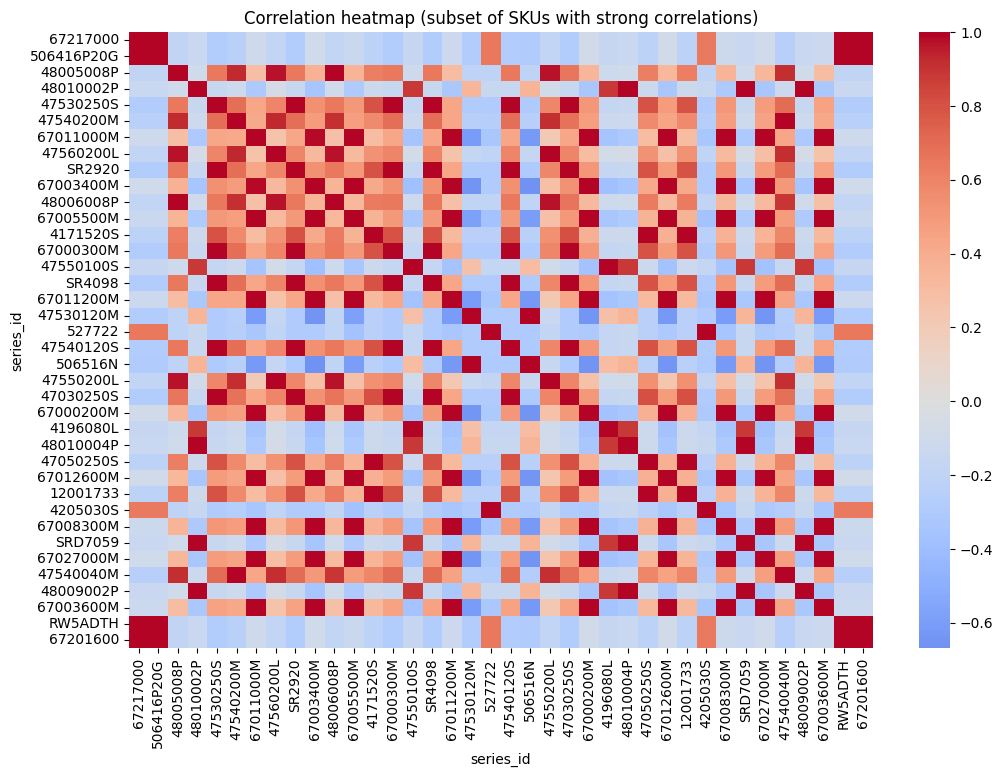

In [6]:
# Heatmap visualization of the submatrix (optional, for first 30 SKUs)
subset_skus = list(set(strong_pairs["sku_1"].head(30)) | set(strong_pairs["sku_2"].head(30)))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.loc[subset_skus, subset_skus], cmap="coolwarm", center=0, annot=False)
plt.title("Correlation heatmap (subset of SKUs with strong correlations)")
plt.show()

In [7]:
series = df[['series_id','timestamp','ADD']].copy()  
exog = df[['series_id','timestamp','sin_week','cos_week','week_number']].copy()  

series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])

display(series.head())
print("")
display(exog.head())

series_id  timestamp   ADD
0  12000210 2024-07-03  9.85
1  12000210 2024-07-10  9.09
2  12000210 2024-07-17  8.71
3  12000210 2024-07-24  8.71
4  12000210 2024-07-31  8.71

series_id  timestamp  sin_week  cos_week  week_number
0  12000210 2024-07-03 -0.120537 -0.992709            1
1  12000210 2024-07-10 -0.239316 -0.970942            2
2  12000210 2024-07-17 -0.354605 -0.935016            3
3  12000210 2024-07-24 -0.464723 -0.885456            4
4  12000210 2024-07-31 -0.568065 -0.822984            5

### Create a matrix (this is just a test, we are not using the matrix)

In [8]:
import os 
series_matrix = series.pivot(index='series_id', columns = 'timestamp', values = 'ADD')
series_matrix

timestamp  2024-07-03  2024-07-10  2024-07-17  2024-07-24  2024-07-31  \
series_id                                                               
12000210         9.85        9.09        8.71        8.71        8.71   
12000235         0.76        0.76        0.76        0.76        0.76   
12000236         9.09        9.09       10.23       10.23       10.23   
12000237         1.52        1.90        1.52        1.52        0.76   
12000249         2.65        2.65        3.41        3.79        3.03   
...               ...         ...         ...         ...         ...   
ZE-6-120         0.98        1.01        1.16        1.17        1.17   
ZE-6-200         0.17        0.23        0.23        0.23        0.20   
ZE-6-250         0.02        0.06        0.06        0.06        0.06   
ZE-8-100P        8.79        8.82        8.56        8.06        8.14   
ZE-8-120         2.26        2.21        2.27        2.29        2.38   

timestamp  2024-08-07  2024-08-14  2024-08-21  2024-08-28  2024-09-04  ...  \
series_id                                                              ...   
12000210         8.71        8.71        8.33        8.71        8.33  ...   
12000235         2.27        2.27        2.27        1.52        1.52  ...   
12000236        10.23        7.95        7.95        6.82        1.14  ...   
12000237         0.76        2.27        2.27        2.27        2.27  ...   
12000249         2.65        2.65        3.41        3.79        4.17  ...   
...               ...         ...         ...         ...         ...  ...   
ZE-6-120         1.32        1.33        1.12        1.25        1.30  ...   
ZE-6-200         0.20        0.20        0.15        0.15        0.30  ...   
ZE-6-250         0.06        0.06        0.05        0.05        0.13  ...   
ZE-8-100P        8.16        8.98        9.01        9.01        8.91  ...   
ZE-8-120         2.47        2.46        2.48        2.46        2.16  ...   

timestamp  2025-05-28  2025-06-04  2025-06-11  2025-06-18  2025-06-25  \
series_id                                                               
12000210         7.58        7.58        6.44        6.06        6.82   
12000235         0.00        0.00        0.00        0.00        0.00   
12000236         2.27        2.27        2.65        2.65        2.65   
12000237         0.00        0.00        0.00        0.00        0.00   
12000249         3.03        3.03        1.52        1.52        0.00   
...               ...         ...         ...         ...         ...   
ZE-6-120         2.16        2.14        1.96        1.88        1.82   
ZE-6-200         0.14        0.14        0.14        0.09        0.05   
ZE-6-250         0.03        0.03        0.03        0.00        0.00   
ZE-8-100P        6.73        6.47        7.09        7.26        7.32   
ZE-8-120         1.41        1.43        1.34        1.37        1.42   

timestamp  2025-07-02  2025-07-09  2025-07-16  2025-07-23  2025-07-30  
series_id                                                              
12000210         6.82        6.82        7.95        5.68        5.68  
12000235         0.00        0.00        0.00        0.00        0.00  
12000236         1.14        1.52        1.14        1.14        1.14  
12000237         0.00        0.00        0.00        0.00        0.00  
12000249         0.00        0.00        0.00        0.00        0.00  
...               ...         ...         ...         ...         ...  
ZE-6-120         1.91        1.87        1.73        1.60        1.31  
ZE-6-200         0.05        0.05        0.08        0.08        0.08  
ZE-6-250         0.00        0.00        0.00        0.00        0.00  
ZE-8-100P        8.91        9.37        9.49        9.70        9.87  
ZE-8-120         2.02        2.03        2.06        2.27        2.35  

[4289 rows x 57 columns]

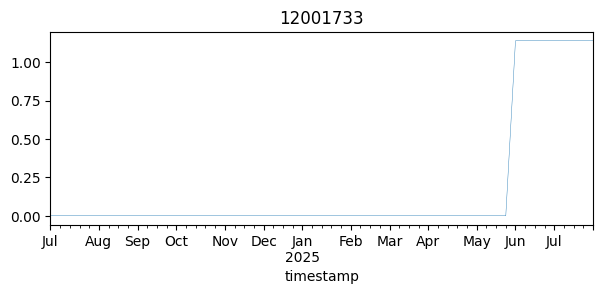

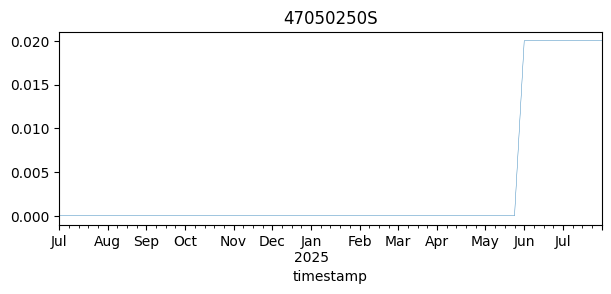

In [9]:
series_to_plot = [
    '12001733',
    '47050250S'
]

for series_id in series_to_plot:
    fig, ax = plt.subplots(1, 1, figsize=(7, 2.5))
    df.query('series_id == @series_id').plot(
        x='timestamp',
        y=['ADD'],
        ax=ax,
        title=series_id,
        linewidth=0.3,
        legend=False,
    )
    plt.show()

### SPLIT TRAIN/TEST by date (test: last 4 weeks)

In [10]:
last_date  = series['timestamp'].max()
end_train  = (last_date - pd.Timedelta(weeks=4))
start_test = end_train + pd.Timedelta(weeks=1)

print("Global split:")
print("  end_train :", end_train.date())
print("  start_test:", start_test.date(), " -> last_date:", last_date.date())

series_train = series.loc[series['timestamp'] <= end_train].copy()
series_test  = series.loc[series['timestamp'] >= start_test].copy()

exog_train   = exog.loc[exog['timestamp'] <= end_train].copy()
exog_test    = exog.loc[exog['timestamp'] >= start_test].copy()

print("Shapes -> series_train:", series_train.shape, " | series_test:", series_test.shape)

Global split:
  end_train : 2025-07-02
  start_test: 2025-07-09  -> last_date: 2025-07-30
Shapes -> series_train: (227317, 3)  | series_test: (17156, 3)


#### NORMALIZATION (Z SCALER) - USING ONLY TRAIN DATA (MU AND SIGMA)

- z_ADD is thestandarized target we will use in the model 
- ADD will be the y true in the original scale

In [11]:
stats_train = (
    series_train
    .groupby('series_id')['ADD']
    .agg(mu='mean', sigma=lambda x: x.std(ddof=0))
    .reset_index()
)
stats_train['sigma'] = stats_train['sigma'].replace(0.0, 1.0)

# Join stats to train and test
series_train = series_train.merge(stats_train[['series_id', 'mu', 'sigma']],
                                  on='series_id', how='left')
series_test  = series_test.merge(stats_train[['series_id', 'mu', 'sigma']],
                                 on='series_id', how='left')
# Compute z_ADD
series_train['z_ADD'] = (series_train['ADD'] - series_train['mu']) / series_train['sigma']
series_test['z_ADD']  = (series_test['ADD']  - series_test['mu'])  / series_test['sigma']
series_train

series_id  timestamp   ADD        mu     sigma     z_ADD
0       12000210 2024-07-03  9.85  6.925472  2.484075  1.177311
1       12000210 2024-07-10  9.09  6.925472  2.484075  0.871362
2       12000210 2024-07-17  8.71  6.925472  2.484075  0.718387
3       12000210 2024-07-24  8.71  6.925472  2.484075  0.718387
4       12000210 2024-07-31  8.71  6.925472  2.484075  0.718387
...          ...        ...   ...       ...       ...       ...
227312  ZE-8-120 2025-06-04  1.43  2.104528  0.434062 -1.553991
227313  ZE-8-120 2025-06-11  1.34  2.104528  0.434062 -1.761335
227314  ZE-8-120 2025-06-18  1.37  2.104528  0.434062 -1.692220
227315  ZE-8-120 2025-06-25  1.42  2.104528  0.434062 -1.577029
227316  ZE-8-120 2025-07-02  2.02  2.104528  0.434062 -0.194738

[227317 rows x 6 columns]

### Prepare data - dictionaries for train and test (Series and exogen features)

In [15]:
series_train = series_train.sort_values(['series_id', 'timestamp'])
series_test = series_test.sort_values(['series_id', 'timestamp'])

# Crear dict train con frecuencia 'W-WED'
series_dict_train = {
    sku: df.set_index('timestamp')['z_ADD'].sort_index().asfreq('W-WED')
    for sku, df in series_train.groupby('series_id', sort=False)
}

# Crear dict test con frecuencia 'W-WED'
series_dict_test = {
    sku: df.set_index('timestamp')['z_ADD'].sort_index().asfreq('W-WED')
    for sku, df in series_test.groupby('series_id', sort=False)
}

exog_train = exog_train.sort_values(['series_id', 'timestamp'])
exog_test = exog_test.sort_values(['series_id', 'timestamp'])

# Crear dict {series_id: pd.DataFrame} sin la columna 'series_id'
exog_dict_train = {
    sku: df.set_index('timestamp').drop(columns=['series_id']).sort_index().asfreq('W-WED')
    for sku, df in exog_train.groupby('series_id', sort=False)
}


# Crear dict {series_id: pd.DataFrame} sin la columna 'series_id'
exog_dict_test = {
    sku: df.set_index('timestamp').drop(columns=['series_id']).sort_index().asfreq('W-WED')
    for sku, df in exog_test.groupby('series_id', sort=False)
}

print("Dict sizes -> series_train:", len(series_dict_train), " | series_test:", len(series_dict_test))
print("Example train series length:", next(iter(series_dict_train.values())).shape)
print("Example test series length :", next(iter(series_dict_test.values())).shape)

Dict sizes -> series_train: 4289  | series_test: 4289
Example train series length: (53,)
Example test series length : (4,)


### Plot initial train/test data

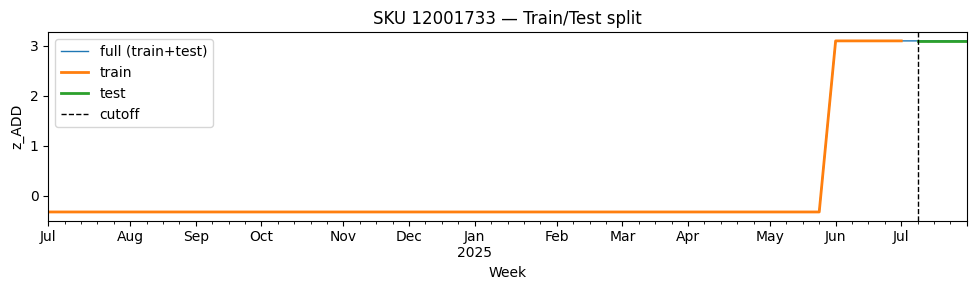

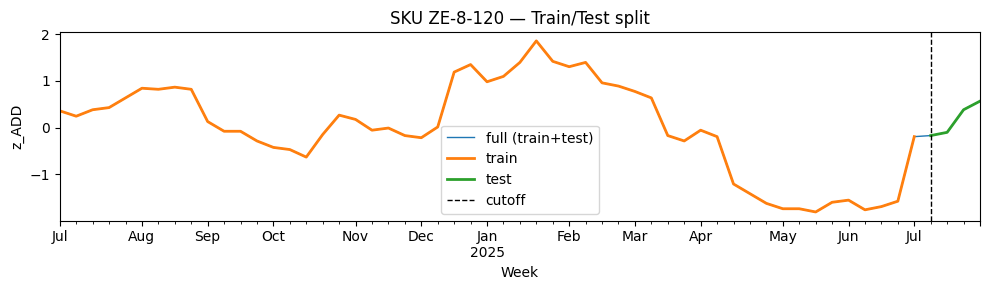

In [16]:
# Plot train/test split per SKU using dicts built from splits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example: choose SKUs to plot (use your own or random sample)
all_levels = sorted(set(series_dict_train.keys()) | set(series_dict_test.keys()))
rng = np.random.default_rng(42)
skus_to_plot = ['12001733', 'ZE-8-120']  # or: rng.choice(all_levels, size=min(4, len(all_levels)), replace=False)

for sku in skus_to_plot:
    if sku not in series_dict_train and sku not in series_dict_test:
        print(f"SKU {sku} not found in train or test; skipping.")
        continue

    # Build "full" by concatenating train and test (when available)
    parts = []
    if sku in series_dict_train:
        parts.append(series_dict_train[sku])
    if sku in series_dict_test:
        parts.append(series_dict_test[sku])
    series_full = pd.concat(parts).sort_index()

    fig, ax = plt.subplots(figsize=(10, 3))

    # Full series (light gray)
    if len(series_full) > 0:
        series_full.plot(ax=ax, label='full (train+test)', linewidth=1.0)

    # Train (blue)
    if sku in series_dict_train and len(series_dict_train[sku]) > 0:
        series_dict_train[sku].plot(ax=ax, label='train', linewidth=2)

    # Test (orange)
    if sku in series_dict_test and len(series_dict_test[sku]) > 0:
        series_dict_test[sku].plot(ax=ax, label='test', linewidth=2)

    # Vertical cutoff at start_test
    if 'start_test' in globals():
        ax.axvline(x=start_test, color='black', linestyle='--', linewidth=1, label='cutoff')

    ax.set_title(f"SKU {sku} — Train/Test split")
    ax.set_ylabel("z_ADD")   # <- usa 'ADD' si estás en escala original
    ax.set_xlabel("Week")
    ax.legend()
    plt.tight_layout()
    plt.show()


Parece que hay un salto pero en realidad es porque el muestreo es semanalmente y en el salto del train a test se esta dejando los dias entre miercoles y miercoles, pero no es un fallo

### Initial FORECASTER with LGBM Regressor

In [ ]:
lags_base = [1, 2, 3, 4]

# Baseline LightGBM hyperparameters (regularized; modest depth/leaves)
lgbm = LGBMRegressor(
    random_state=RANDOM_STATE,
    n_estimators=600,        # enough trees; grid will tune
    learning_rate=0.05,
    # max_depth=-1,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1
)


# Global multi-series recursive forecaster
forecaster = ForecasterRecursiveMultiSeries(
    regressor=lgbm,
    lags=lags_base,
    encoding="ordinal"  # compact encoding for series id
)

forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [1 2 3 4] 
Window features: None 
Window size: 4 
Series encoding: ordinal 
Series names (levels): None 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8,
    'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 600, 'n_jobs': -1, 'num_leaves': 63, 'objective': None,
    'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.8,
    'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2025-09-15 12:01:46 
Last fit date: None 
Skforecast version: 0.17.0 
Python version: 3.13.5 
Forecaster id: None

### Lags and Hyperparameter tuning - Cross Validation with bayesian_search_forecaster_multiseries & OneStepAheadFold

In [19]:
from skforecast.model_selection import (
    OneStepAheadFold,
    bayesian_search_forecaster_multiseries
)
from skforecast.preprocessing import RollingFeatures


# 1) Definir el tamaño del tramo de validación interno dentro del training: 10 semanas de validacion, evaluadas de 1 en 1 steps
n_val_weeks_osa = 10
n_total_weeks_train = len(next(iter(series_dict_train.values())))
initial_train_size = n_total_weeks_train - n_val_weeks_osa
assert initial_train_size > 8, "Very small training window. Reduce n_val_weeks_osa."

def search_space(trial):
    return {
        # Lags cortos por historia ~57 semanas; añade variantes si quieres.
        'lags'            : trial.suggest_categorical('lags', [
                              [1,2,3,4],
                              [1,2,3,4,8],
                              [1,2,3,4,8,12],
                              [1,2,3,4,8,12,24]]),
        'n_estimators'    : trial.suggest_int('n_estimators', 200, 800, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 8, step=1),
        'num_leaves'      : trial.suggest_int('num_leaves', 15, 63, step=4),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200, step=10),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0, step=0.1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0, step=0.1),
        'lambda_l1'       : trial.suggest_float('lambda_l1', 0.0, 1.0, step=0.1),
        'lambda_l2'       : trial.suggest_float('lambda_l2', 0.0, 1.0, step=0.1),
    }


cv_osa = OneStepAheadFold(initial_train_size=initial_train_size)

results_search, best_trial = bayesian_search_forecaster_multiseries(
    forecaster        = forecaster,
    series            = series_dict_train,
    exog              = exog_dict_train,   # si no tienes exógenas por serie, pasa None
    cv                = cv_osa,
    search_space      = search_space,
    n_trials          = 20,                # ajusta según presupuesto
    metric            = "mean_absolute_error",
    return_best       = True,
    suppress_warnings = True,
    random_state      = RANDOM_STATE,
    n_jobs            = "auto",
    verbose           = True
)

best_params = results_search.at[0, 'params']
best_lags   = results_search.at[0, 'lags']

print("Best lags:", best_lags)
print("Best params:", best_params)


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.8 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.8 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.


Best trial: 0. Best value: 0.314052:   5%|▌         | 1/20 [00:13<04:23, 13.87s/it]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001948 seconds.


Best trial: 0. Best value: 0.314052:  10%|█         | 2/20 [00:25<03:44, 12.45s/it]

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.7000000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.7000000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise mul

Best trial: 0. Best value: 0.314052:  15%|█▌        | 3/20 [00:38<03:34, 12.60s/it]

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.8 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.8 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003865 seconds.


Best trial: 0. Best value: 0.314052:  20%|██        | 4/20 [00:51<03:26, 12.91s/it]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.30000000000000004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.30000000000000004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8 will be ignored. Current valu

Best trial: 4. Best value: 0.312774:  25%|██▌       | 5/20 [01:05<03:20, 13.35s/it]

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004535 seconds.


Best trial: 4. Best value: 0.312774:  30%|███       | 6/20 [01:20<03:16, 14.02s/it]

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.


Best trial: 4. Best value: 0.312774:  35%|███▌      | 7/20 [01:34<03:00, 13.87s/it]

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.30000000000000004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.30000000000000004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise

Best trial: 4. Best value: 0.312774:  40%|████      | 8/20 [01:48<02:45, 13.78s/it]

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9
[LightGBM] [Warning] lambda_l2 is set=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9
[LightGBM] [Warning] lambda_l2 is set=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001576 seconds.


Best trial: 4. Best value: 0.312774:  45%|████▌     | 9/20 [02:01<02:31, 13.81s/it]

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001182 seconds.


Best trial: 4. Best value: 0.312774:  50%|█████     | 10/20 [02:17<02:24, 14.46s/it]

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.30000000000000004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.30000000000000004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current valu

Best trial: 10. Best value: 0.31219:  55%|█████▌    | 11/20 [02:33<02:13, 14.78s/it]

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.30000000000000004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.30000000000000004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current valu

Best trial: 10. Best value: 0.31219:  60%|██████    | 12/20 [02:49<02:00, 15.05s/it]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.30000000000000004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.30000000000000004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current valu

Best trial: 12. Best value: 0.309295:  65%|██████▌   | 13/20 [03:03<01:44, 14.97s/it]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: b

Best trial: 12. Best value: 0.309295:  70%|███████   | 14/20 [03:21<01:34, 15.75s/it]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise mul

Best trial: 14. Best value: 0.308734:  75%|███████▌  | 15/20 [03:39<01:21, 16.37s/it]

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.6000000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.6000000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: baggi

Best trial: 14. Best value: 0.308734:  80%|████████  | 16/20 [03:59<01:09, 17.45s/it]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.6000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.6000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing row-wise mul

Best trial: 14. Best value: 0.308734:  85%|████████▌ | 17/20 [04:16<00:52, 17.43s/it]

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004921 seconds.


Best trial: 14. Best value: 0.308734:  90%|█████████ | 18/20 [04:35<00:36, 18.01s/it]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005290 seconds.


Best trial: 14. Best value: 0.308734:  95%|█████████▌| 19/20 [04:55<00:18, 18.42s/it]

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.6000000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.6000000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: baggi

Best trial: 14. Best value: 0.308734: 100%|██████████| 20/20 [05:08<00:00, 15.45s/it]
c:\Users\maria.diazalba\OneDrive - Cordis US Corp\0 MARIA\SKU Demand\venv_psr\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 3, 4] which is of type list.
  warnings.warn(message)
c:\Users\maria.diazalba\OneDrive - Cordis US Corp\0 MARIA\SKU Demand\venv_psr\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 3, 4, 8] which is of type list.
  warnings.warn(message)
c:\Users\maria.diazalba\OneDrive - Cordis US Corp\0 MARIA\SKU Demand\venv_psr\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but con

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise mul

In [26]:
# MANUAL SELECTION - To avoid running the tuning code (long time)
best_lags= [1, 2, 3, 4]
best_params= {'n_estimators': 300, 'max_depth': 7, 'num_leaves': 47, 'min_child_samples': 160, 'learning_rate': 0.04801856153426353, 'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'lambda_l1': 0.7000000000000001, 'lambda_l2': 0.5}


In [27]:
print(best_lags)
print(best_params)

[1, 2, 3, 4]
{'n_estimators': 300, 'max_depth': 7, 'num_leaves': 47, 'min_child_samples': 160, 'learning_rate': 0.04801856153426353, 'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'lambda_l1': 0.7000000000000001, 'lambda_l2': 0.5}


### Final FORECASTER with the selected parameters

In [28]:
from skforecast.preprocessing import RollingFeatures

regressor = LGBMRegressor(
    random_state=RANDOM_STATE,
    **best_params
)

rolling=RollingFeatures(
    stats        = ['mean', 'mean'],
    window_sizes = [4, 7]
)

forecaster = ForecasterRecursiveMultiSeries(
    regressor=regressor, 
    lags=best_lags,
    window_features=rolling,
    encoding="ordinal", 
    dropna_from_series=False
)

CUIDADO! Este initial_train_size es diferente que el que se uso con OSA

### BACKTESTING WITH TimeSeriesFold

In [29]:
# 12 semanas de validacion, evaluadas de 4 en 4 steps (3 folds)
steps = 4
n_folds_desired = 3
n_val_weeks_tsf = steps * n_folds_desired

initial_train_size = n_total_weeks_train - n_val_weeks_tsf

# TimeSeriesFold (cross validation real multi-paso h=4)
cv = TimeSeriesFold(
    steps=steps,
    initial_train_size=initial_train_size,
    refit=True,                 # empieza con False por coste; puedes probar True si quieres más realismo
    fixed_train_size=True,       # ventana deslizante del mismo tamaño
    allow_incomplete_fold=True
)

# --- 5) Backtesting dentro del training ---
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster             = forecaster,
    series                 = series_dict_train,   # ¡training!
    exog                   = exog_dict_train,     # exógenas del training
    cv                     = cv,
    levels                 = None,                # todas las series
    metric                 = ["mean_absolute_error"],
    add_aggregated_metric  = True,
    n_jobs                 = "auto",
    verbose                = True,
    show_progress          = True,
    suppress_warnings      = True
)

display(metrics_levels)
print()
display(backtest_predictions.head())

Information of folds
--------------------
Number of observations used for initial training: 41
Number of observations used for backtesting: 12
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 4
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2024-07-03 00:00:00 -- 2025-04-09 00:00:00  (n=41)
    Validation: 2025-04-16 00:00:00 -- 2025-05-07 00:00:00  (n=4)
Fold: 1
    Training:   2024-07-31 00:00:00 -- 2025-05-07 00:00:00  (n=41)
    Validation: 2025-05-14 00:00:00 -- 2025-06-04 00:00:00  (n=4)
Fold: 2
    Training:   2024-08-28 00:00:00 -- 2025-06-04 00:00:00  (n=41)
    Validation: 2025-06-11 00:00:00 -- 2025-07-02 00:00:00  (n=4)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.70000000000

 33%|███▎      | 1/3 [00:03<00:06,  3.41s/it]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set

 67%|██████▋   | 2/3 [00:13<00:07,  7.21s/it]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set

100%|██████████| 3/3 [00:23<00:00,  7.70s/it]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set

levels  mean_absolute_error
0             12000210             0.484428
1             12000235             0.181890
2             12000236             0.369099
3             12000237             0.164496
4             12000249             0.431156
...                ...                  ...
4287         ZE-8-100P             0.733761
4288          ZE-8-120             0.837903
4289           average             0.462141
4290  weighted_average             0.462141
4291           pooling             0.462141

[4292 rows x 2 columns]

level      pred
2025-04-16  12000210 -1.262285
2025-04-16  12000235 -0.480594
2025-04-16  12000236  0.105016
2025-04-16  12000237 -0.989701
2025-04-16  12000249 -0.679491

### Metric Levels DataFrame
metrics_levels (4289 rows)
- level = sku instances
- z_mae : mean_absolute_error (z scale)

creamos:
- sigma
- mu
- mae (original scale)

In [30]:
metrics_levels = metrics_levels.rename(columns={"levels": "level"})

metrics_levels = metrics_levels.drop(metrics_levels.tail(3).index)

metrics_levels = (
    metrics_levels.merge(
        stats_train[["series_id", "sigma", "mu"]],  # seleccionamos solo esas
        left_on="level",    # clave en df1
        right_on="series_id",  # clave en df2
        how="left"                      # left: mantiene todos los de df1
    )
    .drop(columns="series_id")
)

metrics_levels = metrics_levels.rename(columns={"mean_absolute_error": "z_mae"})

metrics_levels['mae'] = metrics_levels['z_mae'] * metrics_levels["sigma"].fillna(0.0)

metrics_levels

level     z_mae     sigma        mu       mae
0      12000210  0.484428  2.484075  6.925472  1.203355
1      12000235  0.181890  0.855023  0.858679  0.155520
2      12000236  0.369099  2.953596  2.781321  1.090168
3      12000237  0.164496  0.851166  0.937925  0.140013
4      12000249  0.431156  2.328633  4.968679  1.004004
...         ...       ...       ...       ...       ...
4284   ZE-6-120  0.643893  0.399794  1.587170  0.257425
4285   ZE-6-200  0.884082  0.062344  0.210000  0.055117
4286   ZE-6-250  0.539614  0.039315  0.075283  0.021215
4287  ZE-8-100P  0.733761  0.736023  8.451509  0.540065
4288   ZE-8-120  0.837903  0.434062  2.104528  0.363702

[4289 rows x 5 columns]

### Backtest_predictions DataFrame

backtest_predictions (51468 rows)
- level = sku individual
- pred (z scale)

creamos:
- z_ADD (real ADD in z scale)
- abs_error (in z scale)
- pred (original scale)
- ADD (real ADD in normal scale)

In [31]:
backtest_predictions = backtest_predictions.rename(columns={"pred": "z_pred"})

y_true_rows = []
for idx, row in backtest_predictions.iterrows():
    level = row["level"]
    date = idx
    y_real = series_dict_train[level].loc[date]  #NORMALIZADOS INICIALES
    y_true_rows.append(y_real)

backtest_predictions["z_ADD"] = y_true_rows

backtest_predictions["z_abs_error"] = (backtest_predictions["z_pred"] - backtest_predictions["z_ADD"]).abs()



backtest_predictions = (
    backtest_predictions.merge(
        stats_train[["series_id", "sigma", "mu"]],  # seleccionamos solo esas
        left_on="level",    # clave en df1
        right_on="series_id",  # clave en df2
        how="left"                      # left: mantiene todos los de df1
    )
    .drop(columns="series_id")
)

backtest_predictions["pred_original"] = (
    backtest_predictions["z_pred"] * backtest_predictions["sigma"] + backtest_predictions["mu"]
)

backtest_predictions["ADD_original"] = (
    backtest_predictions["z_ADD"] * backtest_predictions["sigma"] + backtest_predictions["mu"]
)

backtest_predictions

level    z_pred     z_ADD  z_abs_error     sigma        mu  \
0       12000210 -1.262285 -0.501382     0.760902  2.484075  6.925472   
1       12000235 -0.480594 -0.559844     0.079249  0.855023  0.858679   
2       12000236  0.105016 -0.044461     0.149477  2.953596  2.781321   
3       12000237 -0.989701 -1.101928     0.112227  0.851166  0.937925   
4       12000249 -0.679491 -0.832540     0.153049  2.328633  4.968679   
...          ...       ...       ...          ...       ...       ...   
51463   ZE-6-120  1.496200  0.807491     0.688709  0.399794  1.587170   
51464   ZE-6-200 -0.852438 -2.566400     1.713962  0.062344  0.210000   
51465   ZE-6-250 -0.952833 -1.914864     0.962031  0.039315  0.075283   
51466  ZE-8-100P -0.570243  0.622930     1.193172  0.736023  8.451509   
51467   ZE-8-120 -0.639070 -0.194738     0.444332  0.434062  2.104528   

       pred_original  ADD_original  
0           3.789862          5.68  
1           0.447760          0.38  
2           3.091495          2.65  
3           0.095524          0.00  
4           3.386395          3.03  
...              ...           ...  
51463       2.185342          1.91  
51464       0.156855          0.05  
51465       0.037822          0.00  
51466       8.031798          8.91  
51467       1.827132          2.02  

[51468 rows x 8 columns]

### Metrics : zMAE (scaled) & MAE (original scale)

In [32]:
z_mae_global = metrics_levels["z_mae"].mean()
mae_global = metrics_levels["mae"].mean()

print(f"Normalized MAE global: {z_mae_global:.4f}")
print(f"MAE global: {mae_global:.4f}")

Normalized MAE global: 0.4621
MAE global: 3.5680


* Normalized MAE global = 0.0501

→ En promedio, el error equivale al 5 % de una desviación estándar en los datos normalizados por fila (Z-score).

→ Esto es muy pequeño, o sea, tu modelo acierta bastante bien en la escala estandarizada.

* MAE global = 0.3163 (escala original)

→ Al deshacer la normalización fila a fila (multiplicando cada error z por la σ correspondiente), obtienes que en las unidades originales (tu ADD), el error medio absoluto es de 0.3163 unidades de demanda promedio por fila.

### Plot backtesting predictions vs real values (original scale of ADD)
Observaciones: se predice mas o menos bien salvo picos finales


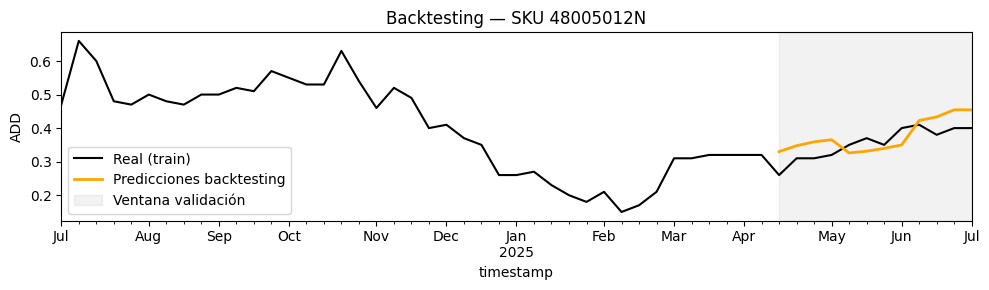

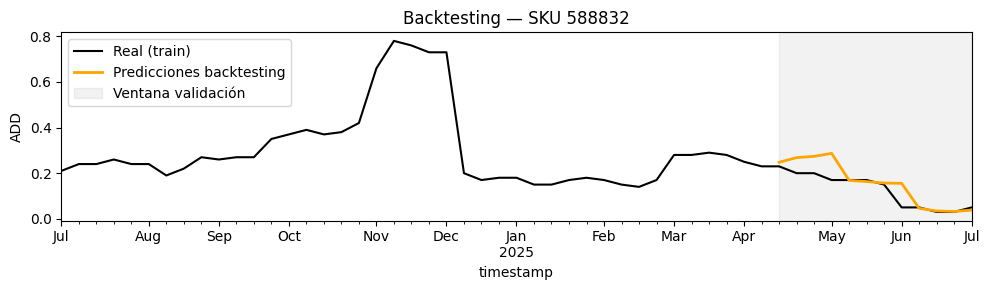

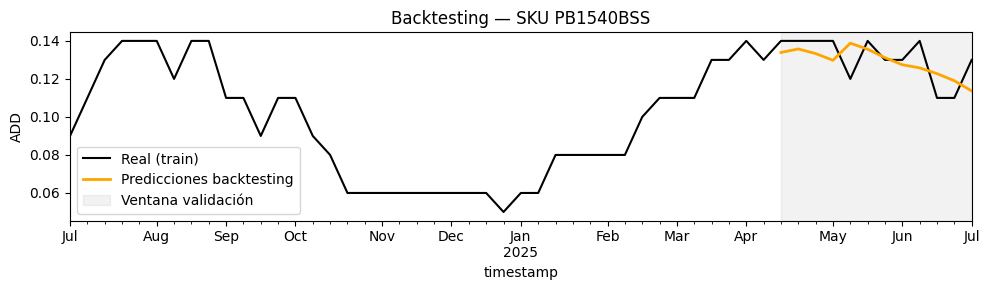

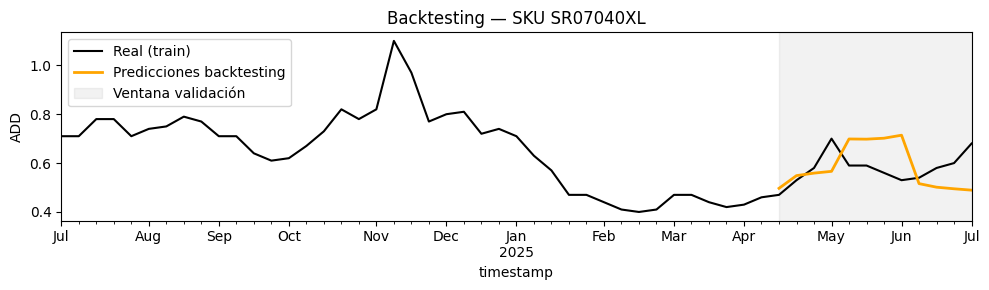

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Asegurar orden temporal
series_train = series_train.sort_values(["series_id", "timestamp"])

# SKUs a graficar (máx. 4 al azar)
all_skus = series_train["series_id"].unique()
skus_to_plot = np.random.choice(all_skus, size=min(4, len(all_skus)), replace=False)

for sku in skus_to_plot:
    fig, ax = plt.subplots(figsize=(10, 3))

    # Serie real (train)
    s_train = series_train[series_train["series_id"] == sku]
    s_train = s_train.set_index("timestamp")["ADD"].sort_index()
    s_train.plot(ax=ax, color="black", label="Real (train)")

    # Predicciones del backtesting para el SKU
    preds_sku = backtest_predictions.loc[backtest_predictions["level"] == sku, "pred_original"].reset_index(drop=True)

    # Índice temporal de validación (últimas n_val_weeks_tsf semanas del train)
    val_idx = s_train.index[-n_val_weeks_tsf:]

    if len(preds_sku) == len(val_idx):
        preds_sku.index = val_idx
        preds_sku.plot(ax=ax, color="orange", linewidth=2, label="Predicciones backtesting")

        # Sombreado validación
        ax.axvspan(val_idx.min(), val_idx.max(), color="gray", alpha=0.1, label="Ventana validación")

    ax.set_title(f"Backtesting — SKU {sku}")
    ax.set_ylabel("ADD")
    ax.legend()
    plt.tight_layout()
    plt.show()


In [34]:
filter1 = backtest_predictions[backtest_predictions['level'] == "12004943"]
filter1

level    z_pred     z_ADD  z_abs_error       sigma          mu  \
26     12004943  0.686399 -0.020869     0.707269  254.431708  557.429811   
4315   12004943  0.845914  0.041662     0.804252  254.431708  557.429811   
8604   12004943  1.014175  0.042252     0.971923  254.431708  557.429811   
12893  12004943  1.060191  0.210784     0.849407  254.431708  557.429811   
17182  12004943  0.139734  0.410877     0.271143  254.431708  557.429811   
21471  12004943  0.143890  0.163149     0.019258  254.431708  557.429811   
25760  12004943  0.148508 -0.004205     0.152713  254.431708  557.429811   
30049  12004943  0.199419 -0.051251     0.250669  254.431708  557.429811   
34338  12004943 -0.063839  0.039265     0.103103  254.431708  557.429811   
38627  12004943 -0.098121  0.064301     0.162422  254.431708  557.429811   
42916  12004943 -0.087594  0.110129     0.197722  254.431708  557.429811   
47205  12004943 -0.045871 -0.003576     0.042295  254.431708  557.429811   

       pred_original  ADD_original  
26        732.071535        552.12  
4315      772.657265        568.03  
8604      815.468011        568.18  
12893     827.176009        611.06  
17182     592.982579        661.97  
21471     594.040116        598.94  
25760     595.215049        556.36  
30049     608.168224        544.39  
34338     541.187267        567.42  
38627     532.464776        573.79  
42916     535.143229        585.45  
47205     545.758812        556.52

# TEST

In [35]:
# Entrenar el forecaster con todos los datos disponibles
# ==============================================================================
forecaster.fit(series = series_dict_train, exog = exog_dict_train)
forecaster

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise mul

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [1 2 3 4] 
Window features: ['roll_mean_4', 'roll_mean_7'] 
Window size: 7 
Series encoding: ordinal 
Series names (levels): 
    12000210, 12000235, 12000236, 12000237, 12000249, 12000304, 12000608, 12000813,
    12000836, 12001624, 12001733, 12001734, 12001736, 12001737, 12001738,
    12001740, 12001741, 12001743, 12001771, 12001776, 12001855, 12001856,
    12001915, 12003704, 12004924, ..., ZE-15-300, ZE-15-325, ZE-15-350,
    ZE-15-375, ZE-15-400, ZE-20-150, ZE-20-200, ZE-20-225, ZE-20-250, ZE-20-275,
    ZE-20-300, ZE-20-325, ZE-20-350, ZE-20-375, ZE-20-400, ZE-30-200, ZE-30-250,
    ZE-30-300, ZE-30-350, ZE-6-100P, ZE-6-120, ZE-6-200, ZE-6-250, ZE-8-100P,
    ZE-8-120 
Exogenous included: True 
Exogenous names: sin_week, cos_week, week_number 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    '12000210': ['2024-07-03', '2025-07-02'], '12000235': ['2024-07-03',
    '2025-07-02'], '12000236': ['2024-07-03', '2025-07-02'], '12000237':
    ['2024-07-03', '2025-07-02'], '12000249': ['2024-07-03', '2025-07-02'], ...,
    'ZE-6-120': ['2024-07-03', '2025-07-02'], 'ZE-6-200': ['2024-07-03',
    '2025-07-02'], 'ZE-6-250': ['2024-07-03', '2025-07-02'], 'ZE-8-100P':
    ['2024-07-03', '2025-07-02'], 'ZE-8-120': ['2024-07-03', '2025-07-02'] 
Training index type: DatetimeIndex 
Training index frequency: W-WED 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.04801856153426353,
    'max_depth': 7, 'min_child_samples': 160, 'min_child_weight': 0.001,
    'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': None, 'num_leaves':
    47, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda':
    0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0,
    'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'lambda_l1':
    0.7000000000000001, 'lambda_l2': 0.5} 
fit_kwargs: {} 
Creation date: 2025-09-15 12:10:38 
Last fit date: 2025-09-15 12:11:41 
Skforecast version: 0.17.0 
Python version: 3.13.5 
Forecaster id: None

In [36]:
# Importancia de los predictores (top 7)
# ==============================================================================
importance = forecaster.get_feature_importances()
importance.head(7)

feature  importance
6  _level_skforecast        1927
0              lag_1        1827
5        roll_mean_7        1482
7           sin_week        1275
8           cos_week        1173
1              lag_2        1169
2              lag_3        1160

In [83]:
levels_test = list(series_dict_test.keys())
len(levels_test)

predictions = forecaster.predict(
    steps=4,                 # horizonte de 8 semanas para validar
    levels=levels_test,      # todos los SKUs del test
    exog=exog_dict_test      # exógenas del test
)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set

In [ ]:
predictions = predictions.rename(columns={"pred": "z_pred"})

#
y_true_rows = []
for idx, row in predictions.iterrows():
    level = row["level"]
    date = idx
    y_real = series_dict_test[level].loc[date]  #NORMALIZADOS INICIALES
    y_true_rows.append(y_real)

predictions["z_ADD"] = y_true_rows

#
predictions["z_abs_error"] = (predictions["z_pred"] - predictions["z_ADD"]).abs()


mae = predictions["z_abs_error"].mean()
print(f"Normalized MAE global: {mae:.4f}")
predictions

Normalized MAE global: 0.5244


level    z_pred     z_ADD  z_abs_error
2025-07-09   12000210  0.126833 -0.042459     0.169293
2025-07-09   12000235 -1.024229 -1.004276     0.019952
2025-07-09   12000236 -0.465954 -0.427046     0.038908
2025-07-09   12000237 -1.101118 -1.101928     0.000811
2025-07-09   12000249 -2.043379 -2.133732     0.090353
...               ...       ...       ...          ...
2025-07-30   ZE-6-120  0.943446 -0.693281     1.636727
2025-07-30   ZE-6-200 -0.979959 -2.085200     1.105241
2025-07-30   ZE-6-250 -0.993304 -1.914864     0.921560
2025-07-30  ZE-8-100P  0.776396  1.927237     1.150841
2025-07-30   ZE-8-120  0.391743  0.565522     0.173779

[17156 rows x 4 columns]

In [85]:
predictions.index = pd.to_datetime(predictions.index)
predictions.index.name = "timestamp"

# Reset index once to have timestamp as a column
predictions = predictions.reset_index()

# Merge mu/sigma from stats_train
predictions = predictions.merge(
    stats_train[["series_id", "sigma", "mu"]],
    left_on="level",
    right_on="series_id",
    how="left"
).drop(columns="series_id")

# Compute original-scale prediction
predictions["pred_original"] = (
    predictions["z_pred"] * predictions["sigma"] + predictions["mu"]
)

# Merge ADD original from df (ground truth)
predictions = predictions.merge(
    df[["series_id", "timestamp", "ADD"]],
    left_on=["level", "timestamp"],
    right_on=["series_id", "timestamp"],
    how="left"
).drop(columns="series_id")


# Rename for clarity
predictions = predictions.rename(columns={"ADD": "ADD_original"})
predictions["abs_error"] = (predictions["pred_original"] - predictions["ADD_original"]).abs()

predictions

timestamp      level    z_pred     z_ADD  z_abs_error     sigma  \
0     2025-07-09   12000210  0.126833 -0.042459     0.169293  2.484075   
1     2025-07-09   12000235 -1.024229 -1.004276     0.019952  0.855023   
2     2025-07-09   12000236 -0.465954 -0.427046     0.038908  2.953596   
3     2025-07-09   12000237 -1.101118 -1.101928     0.000811  0.851166   
4     2025-07-09   12000249 -2.043379 -2.133732     0.090353  2.328633   
...          ...        ...       ...       ...          ...       ...   
17151 2025-07-30   ZE-6-120  0.943446 -0.693281     1.636727  0.399794   
17152 2025-07-30   ZE-6-200 -0.979959 -2.085200     1.105241  0.062344   
17153 2025-07-30   ZE-6-250 -0.993304 -1.914864     0.921560  0.039315   
17154 2025-07-30  ZE-8-100P  0.776396  1.927237     1.150841  0.736023   
17155 2025-07-30   ZE-8-120  0.391743  0.565522     0.173779  0.434062   

             mu  pred_original  ADD_original  abs_error  
0      6.925472       7.240535          6.82   0.420535  
1      0.858679      -0.017060          0.00   0.017060  
2      2.781321       1.405082          1.52   0.114918  
3      0.937925       0.000690          0.00   0.000690  
4      4.968679       0.210400          0.00   0.210400  
...         ...            ...           ...        ...  
17151  1.587170       1.964354          1.31   0.654354  
17152  0.210000       0.148905          0.08   0.068905  
17153  0.075283       0.036231          0.00   0.036231  
17154  8.451509       9.022955          9.87   0.847045  
17155  2.104528       2.274569          2.35   0.075431  

[17156 rows x 10 columns]

In [40]:
output_path = os.path.join('./results', 'predictions.xlsx')
predictions.to_excel(output_path, index=False)

### TEST MAE & NORMALIZED MAE

In [86]:
z_mae_global = predictions["z_abs_error"].mean()
mae_global = predictions["abs_error"].mean()

print(f"Normalized MAE global: {z_mae_global:.4f}")
print(f"MAE global: {mae_global:.4f}")

Normalized MAE global: 0.5244
MAE global: 2.9279


In [87]:
errors_por_snapshot = (
    predictions
    .groupby("timestamp")
    .agg(
        mae=("abs_error", "mean"),
        z_mae=("z_abs_error", "mean"),
        n=("abs_error", "size")  # cuántas predicciones entran en el promedio
    )
    .sort_index()
    .reset_index()
)
snapshots_ordenados = errors_por_snapshot["timestamp"].sort_values().unique()

map_h = {ts: f"t+{i+1}" for i, ts in enumerate(snapshots_ordenados)}
errors_por_snapshot["horizon"] = errors_por_snapshot["timestamp"].map(map_h)
errors_por_snapshot

timestamp       mae     z_mae     n horizon
0 2025-07-09  1.716837  0.277782  4289     t+1
1 2025-07-16  2.144166  0.423315  4289     t+2
2 2025-07-23  4.168462  0.666189  4289     t+3
3 2025-07-30  3.682100  0.730292  4289     t+4

502521
       pred_original  ADD_original    abs_error
1408     9921.001687      10103.53   182.528313
5697     9707.062122      10068.30   361.237878
9986     9411.417604       8260.80  1150.617604
14275    9410.383522       8155.88  1254.503522
MAE 737.2218289933514


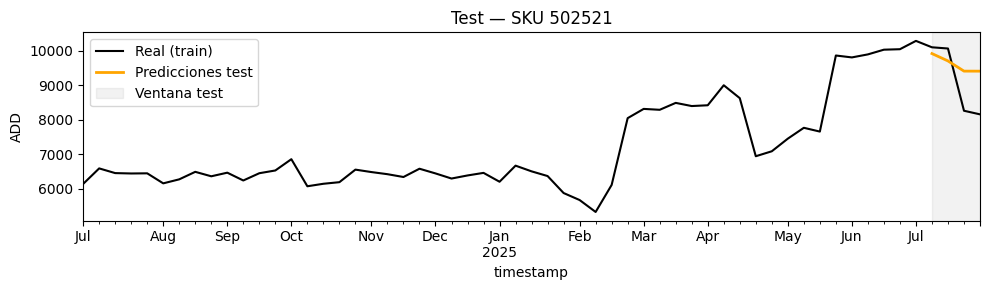

504606X
       pred_original  ADD_original    abs_error
1514     6794.395915       6378.64   415.755915
5803     6739.753599       6396.98   342.773599
10092    6453.685508       4581.53  1872.155508
14381    6506.544152       5195.99  1310.554152
MAE 985.3097933053502


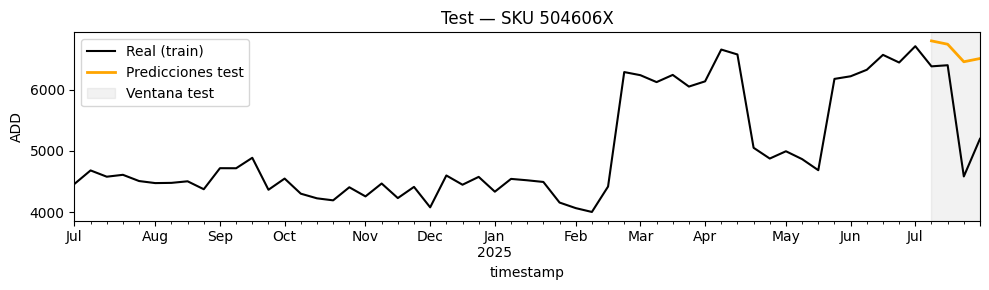

67005400
       pred_original  ADD_original   abs_error
2307     1438.323771       1432.70    5.623771
6596     1434.143207       1410.43   23.713207
10885    1462.974327       1016.34  446.634327
15174    1481.743529       1052.24  429.503529
MAE 226.36870832998616


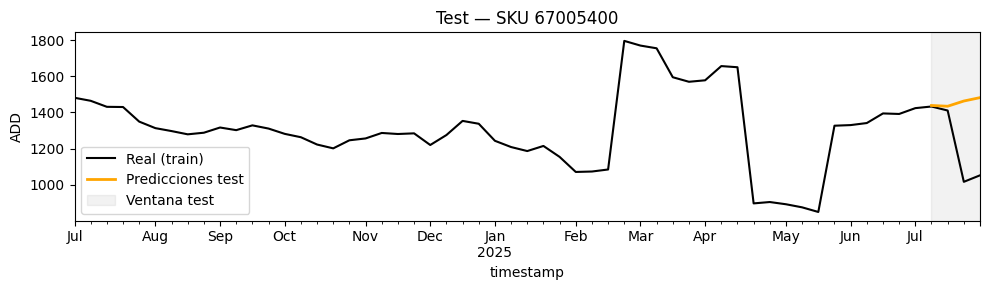

In [88]:
# Asegurar orden temporal
series = series.sort_values(["series_id", "timestamp"])

## SKUs a graficar (máx. 4 al azar)
all_skus = series["series_id"].unique()
#skus_to_plot = np.random.choice(all_skus, size=min(4, len(all_skus)), replace=False)
skus_to_plot = ['502521', '504606X', '67005400']

n_test_weeks = 4 

for sku in skus_to_plot:

    print(sku)
    df_sku = (predictions.loc[predictions["level"].astype(str) == sku,
                         ["pred_original", "ADD_original", "abs_error"]]
                    .sort_index())
    print(df_sku)
    print(f"MAE {df_sku["abs_error"].mean()}")

    fig, ax = plt.subplots(figsize=(10, 3))

    # Serie real (entera)
    s_full  = series[series["series_id"] == sku]
    s_full  = s_full .set_index("timestamp")["ADD"].sort_index()
    s_full .plot(ax=ax, color="black", label="Real (train)")

    # Predicciones del test para el SKU
    preds_sku = predictions.loc[predictions["level"] == sku, "pred_original"].reset_index(drop=True)

    # Índice temporal de test
    test_idx = s_full.index[-n_test_weeks:]

    if len(preds_sku) == len(test_idx):
        preds_sku.index = test_idx
        preds_sku.plot(ax=ax, color="orange", linewidth=2, label="Predicciones test")

        # Sombreado validación
        ax.axvspan(test_idx.min(), test_idx.max(), color="gray", alpha=0.1, label="Ventana test")

    ax.set_title(f"Test — SKU {sku}")
    ax.set_ylabel("ADD")
    ax.legend()
    plt.tight_layout()
    plt.show()

### MORE METRICS

In [89]:
from sklearn.metrics import mean_absolute_error

def smape(y_true, y_pred, eps=1e-10):
    denom = (np.abs(y_true) + np.abs(y_pred)).clip(lower=eps)
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def rmsse(y_true, y_pred, y_insample):
    num = np.sqrt(np.mean((y_true - y_pred)**2))
    denom = np.sqrt(np.mean((y_insample[1:] - y_insample[:-1])**2))
    return num / denom if denom > 0 else np.nan

def mase(y_true, y_pred, y_insample, m=1):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    ins = np.asarray(y_insample, dtype=float)

    num = np.mean(np.abs(y_true - y_pred))  # MAE out-of-sample

    # Denominador: MAE del naïve in-sample (lag m)
    ins = ins[~np.isnan(ins)]
    if ins.size <= m:
        return np.nan
    denom = np.mean(np.abs(ins[m:] - ins[:-m]))
    return num / denom if denom > 0 else np.nan

# --- Global metrics ---
y_true = predictions["ADD_original"]
y_pred = predictions["pred_original"]

mae = mean_absolute_error(y_true, y_pred)
mse = np.mean((y_true - y_pred) ** 2)
rmse = float(np.sqrt(mse))

smape_val = smape(y_true, y_pred)

series_dict_train_add = {
    sku: df.set_index('timestamp')['ADD'].sort_index().asfreq('W-WED')
    for sku, df in series_train.groupby('series_id', sort=False)
}

rmsse_vals, mase_vals = [], []
for sku, g in predictions.groupby("level", sort=False):
    y_true_sku = g["ADD_original"].to_numpy()
    y_pred_sku = g["pred_original"].to_numpy()

    # IMPORTANTE: in-sample en escala original (ADD), no z_ADD
    y_insample = series_dict_train_add.get(sku)
    y_insample_vals = None if y_insample is None else y_insample.to_numpy()

    # RMSSE (tu función actual)
    rmsse_vals.append(
        rmsse(y_true_sku, y_pred_sku, y_insample_vals) if y_insample_vals is not None else np.nan
    )

    # MASE reutilizando las mismas 3 variables
    mase_vals.append(
        mase(y_true_sku, y_pred_sku, y_insample_vals, m=1)
        if y_insample_vals is not None else np.nan
    )


rmsse_vals = [r for r in rmsse_vals if np.isfinite(r)]
mase_vals = [v for v in mase_vals if np.isfinite(v)]

rmsse_avg = np.mean(rmsse_vals)
mase_avg = float(np.mean(mase_vals)) if mase_vals else np.nan

rmsse_share_below1 = np.mean([r < 1 for r in rmsse_vals])
mase_share_below1 = float(np.mean([v < 1 for v in mase_vals])) if mase_vals else np.nan


# --- Report ---
print(f"MAE      : {mae:.2f}")
print(f"MSE      : {mse:.2f}")
print(f"RMSE     : {rmse:.2f}")
print(f"sMAPE    : {smape_val:.2%}")
print(f"RMSSE    : {rmsse_avg:.2f}")
print(f"% SKUs RMSSE < 1: {rmsse_share_below1:.1%}")
print(f"MASE promedio     : {mase_avg:.3f}")
print(f"% SKUs MASE < 1   : {mase_share_below1:.1%}")



MAE      : 2.93
MSE      : 1098.64
RMSE     : 33.15
sMAPE    : 64.71%
RMSSE    : 1.41
% SKUs RMSSE < 1: 48.0%
MASE promedio     : 2.319
% SKUs MASE < 1   : 31.3%


### RESIDUALS

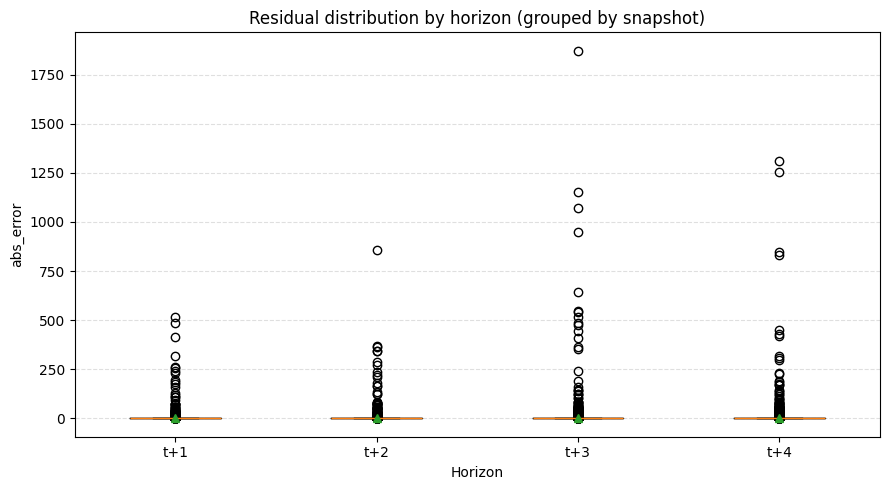

            n      mean    median        std
horizon                                     
t+1      4289  1.716837  0.039139  17.274375
t+2      4289  2.144166  0.066061  20.380150
t+3      4289  4.168462  0.128134  47.222895
t+4      4289  3.682100  0.148178  37.594221


In [90]:
predictions = predictions.copy()
predictions["timestamp"] = pd.to_datetime(predictions["timestamp"])


snapshots = predictions["timestamp"].sort_values().unique()
h_map = {ts: f"t+{i+1}" for i, ts in enumerate(snapshots)}
predictions["horizon"] = predictions["timestamp"].map(h_map)

order = [f"t+{i+1}" for i in range(len(snapshots))]

data = [predictions.loc[predictions["horizon"] == h, "abs_error"].values for h in order]

plt.figure(figsize=(9, 5))
plt.boxplot(data, showmeans=True)
plt.xticks(range(1, len(order) + 1), order)
plt.title("Residual distribution by horizon (grouped by snapshot)")
plt.xlabel("Horizon")
plt.ylabel("abs_error")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

resumen = (
    predictions.groupby("horizon")["abs_error"]
    .agg(n="count", mean="mean", median="median", std="std")
    .reindex(order)
)
print(resumen)


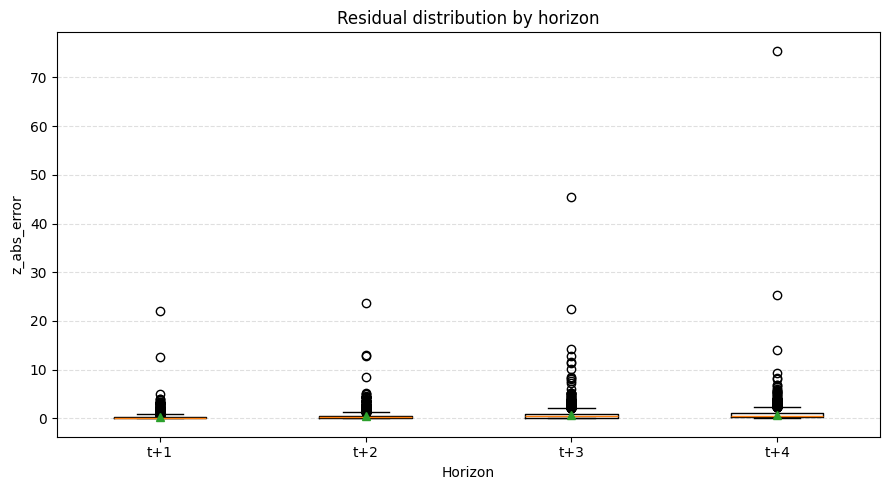

In [91]:
data_z = [predictions.loc[predictions["horizon"] == h, "z_abs_error"].values for h in order]

plt.figure(figsize=(9, 5))
plt.boxplot(data_z, showmeans=True)
plt.xticks(range(1, len(order) + 1), order)
plt.title("Residual distribution by horizon")
plt.xlabel("Horizon")
plt.ylabel("z_abs_error")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### Redondear predicciones (unidades de ADD completas) para simular caso real
- Caso 1: Enfocado en la evaluacion del modelo -  primero la diferencia despues se redondea el error
- Caso 2: Enfocado en la operacionalidad y decisiond e inventario - primero se redondea y luego se calcula la diferencia

In [49]:
casos = predictions[['timestamp','level','pred_original','ADD_original']].copy()  
casos['caso1'] = ((casos['pred_original'] - casos['ADD_original']).abs()).round()
casos['caso2'] = (casos['pred_original'].round() - casos['ADD_original'].round()).abs()

print(casos['caso1'].mean())
print(casos['caso2'].mean())
casos

2.87794357659128
2.921718349265563


timestamp      level  pred_original  ADD_original  caso1  caso2
0     2025-07-09   12000210       7.240535          6.82    0.0    0.0
1     2025-07-09   12000235      -0.017060          0.00    0.0    0.0
2     2025-07-09   12000236       1.405082          1.52    0.0    1.0
3     2025-07-09   12000237       0.000690          0.00    0.0    0.0
4     2025-07-09   12000249       0.210400          0.00    0.0    0.0
...          ...        ...            ...           ...    ...    ...
17151 2025-07-30   ZE-6-120       1.964354          1.31    1.0    1.0
17152 2025-07-30   ZE-6-200       0.148905          0.08    0.0    0.0
17153 2025-07-30   ZE-6-250       0.036231          0.00    0.0    0.0
17154 2025-07-30  ZE-8-100P       9.022955          9.87    1.0    1.0
17155 2025-07-30   ZE-8-120       2.274569          2.35    0.0    0.0

[17156 rows x 6 columns]

In [93]:
from scipy import stats

# --- Config ---
ALPHA = 0.05  # 95% CI

# --- Utilidad: IC t para la media por grupo ---
def mean_ci_t_by_group(df, group_col, value_col, alpha=0.05):
    """
    Devuelve un DataFrame con columnas:
    group_col, n, mean, std, se, tcrit, ci_lo, ci_hi
    """
    g = df.groupby(group_col)[value_col]
    out = g.agg(n='count', mean='mean', std=lambda x: x.std(ddof=1)).reset_index()
    # EE y t crítico
    out['se'] = out['std'] / np.sqrt(out['n'])
    # df = n-1; para n<2 el IC no se puede calcular
    out['df'] = out['n'] - 1
    # t crítico (NaN si df<=0)
    out['tcrit'] = out['df'].apply(lambda dfi: stats.t.ppf(1 - alpha/2, dfi) if dfi>0 else np.nan)
    # IC
    out['ci_lo'] = out['mean'] - out['tcrit'] * out['se']
    out['ci_hi'] = out['mean'] + out['tcrit'] * out['se']
    # orden y nombres
    out = out.rename(columns={
        'mean': f'{value_col}_mae',
        'std': f'{value_col}_std',
        'se':  f'{value_col}_se',
        'ci_lo': f'{value_col}_ci_lo',
        'ci_hi': f'{value_col}_ci_hi'
    })
    return out[[group_col, 'n', 'df', f'{value_col}_mae', f'{value_col}_std',
                f'{value_col}_se', 'tcrit', f'{value_col}_ci_lo', f'{value_col}_ci_hi']]

# --- Limpieza ligera ---
# Asegura que existan las columnas esperadas
required_cols = {'level','timestamp','abs_error','z_abs_error'}
missing = required_cols - set(predictions.columns)
if missing:
    raise ValueError(f'Faltan columnas en predictions: {missing}')

# Asegura timestamp datetime
if not np.issubdtype(predictions['timestamp'].dtype, np.datetime64):
    predictions = predictions.copy()
    predictions['timestamp'] = pd.to_datetime(predictions['timestamp'], errors='coerce')

# --- IC por SKU, en original y en z ---
ci_orig = mean_ci_t_by_group(predictions, 'level', 'abs_error', alpha=ALPHA)
ci_z    = mean_ci_t_by_group(predictions, 'level', 'z_abs_error', alpha=ALPHA)

# Merge de ambas escalas
per_sku = ci_orig.merge(ci_z, on=['level','n','df','tcrit'], how='inner')

# --- (Opcional) Chequeo de sigma por SKU, y conversión z->original ---
if 'sigma' in predictions.columns:
    sig_stats = predictions.groupby('level')['sigma'].agg(sigma_mean='mean',
                                                          sigma_std='std').reset_index()
    per_sku = per_sku.merge(sig_stats, on='level', how='left')
    per_sku['sigma_cv'] = per_sku['sigma_std'] / per_sku['sigma_mean']

    # Re-escalar el IC en z para comparar con el de original
    per_sku['z_to_orig_mae']   = per_sku['z_abs_error_mae']   * per_sku['sigma_mean']
    per_sku['z_to_orig_ci_lo'] = per_sku['z_abs_error_ci_lo'] * per_sku['sigma_mean']
    per_sku['z_to_orig_ci_hi'] = per_sku['z_abs_error_ci_hi'] * per_sku['sigma_mean']


# --- Macro-MAE (promedio de los MAE por SKU) con IC t entre SKUs ---
def macro_mae_ci(per_sku_df, mae_col, alpha=0.05):
    vals = per_sku_df[mae_col].dropna().values
    S = len(vals)
    mean_macro = vals.mean()
    std_between = vals.std(ddof=1) if S>1 else np.nan
    se_between = std_between / np.sqrt(S) if S>1 else np.nan
    tcrit = stats.t.ppf(1 - alpha/2, S-1) if S>1 else np.nan
    ci_lo = mean_macro - tcrit*se_between if S>1 else np.nan
    ci_hi = mean_macro + tcrit*se_between if S>1 else np.nan
    return pd.Series({'S': S, 'mean_macro': mean_macro, 'std_between': std_between,
                      'se_between': se_between, 'tcrit': tcrit, 'ci_lo': ci_lo, 'ci_hi': ci_hi})

macro_orig = macro_mae_ci(per_sku, 'abs_error_mae', alpha=ALPHA)
macro_z    = macro_mae_ci(per_sku, 'z_abs_error_mae', alpha=ALPHA)

# --- Resultados principales ---
# per_sku: IC 95% por SKU (original y z), con checks de sigma si está disponible
# macro_orig / macro_z: resumen a nivel global

# Guarda a CSV (ajusta la ruta si prefieres)
#per_sku.to_csv('per_sku_mae_ci.csv', index=False)


print("\nMacro-MAE (original):")
print(macro_orig)
print("\nMacro-MAE (z):")
print(macro_z)
print("\nArchivo exportado: per_sku_mae_ci.csv")

per_sku



Macro-MAE (original):
S              4289.000000
mean_macro        2.927891
std_between      27.889108
se_between        0.425850
tcrit             1.960517
ci_lo             2.093005
ci_hi             3.762777
dtype: float64

Macro-MAE (z):
S              4289.000000
mean_macro        0.524395
std_between       0.825442
se_between        0.012604
tcrit             1.960517
ci_lo             0.499684
ci_hi             0.549105
dtype: float64

Archivo exportado: per_sku_mae_ci.csv


level  n  df  abs_error_mae  abs_error_std  abs_error_se     tcrit  \
0      12000210  4   3       1.255153       0.895990      0.447995  3.182446   
1      12000235  4   3       0.020142       0.004437      0.002219  3.182446   
2      12000236  4   3       0.406952       0.317440      0.158720  3.182446   
3      12000237  4   3       0.027393       0.032467      0.016234  3.182446   
4      12000249  4   3       1.539945       1.318073      0.659037  3.182446   
...         ... ..  ..            ...            ...           ...       ...   
4284   ZE-6-120  4   3       0.295524       0.267886      0.133943  3.182446   
4285   ZE-6-200  4   3       0.046344       0.018990      0.009495  3.182446   
4286   ZE-6-250  4   3       0.020428       0.013984      0.006992  3.182446   
4287  ZE-8-100P  4   3       0.694995       0.152221      0.076111  3.182446   
4288   ZE-8-120  4   3       0.073691       0.028512      0.014256  3.182446   

      abs_error_ci_lo  abs_error_ci_hi  z_abs_error_mae  z_abs_error_std  \
0           -0.170568         2.680873         0.505280         0.360694   
1            0.013081         0.027202         0.023557         0.005189   
2           -0.098167         0.912070         0.137782         0.107476   
3           -0.024270         0.079055         0.032183         0.038144   
4           -0.557404         3.637294         0.661309         0.566029   
...               ...              ...              ...              ...   
4284        -0.130743         0.721790         0.739190         0.670060   
4285         0.016127         0.076561         0.743358         0.304594   
4286        -0.001824         0.042680         0.519601         0.355697   
4287         0.452778         0.937213         0.944257         0.206816   
4288         0.028323         0.119060         0.169772         0.065686   

      z_abs_error_se  z_abs_error_ci_lo  z_abs_error_ci_hi  sigma_mean  \
0           0.180347          -0.068665           1.079224    2.484075   
1           0.002595           0.015299           0.031814    0.855023   
2           0.053738          -0.033236           0.308800    2.953596   
3           0.019072          -0.028513           0.092879    0.851166   
4           0.283014          -0.239370           1.561987    2.328633   
...              ...                ...                ...         ...   
4284        0.335030          -0.327026           1.805405    0.399794   
4285        0.152297           0.258681           1.228034    0.062344   
4286        0.177848          -0.046392           1.085593    0.039315   
4287        0.103408           0.615168           1.273347    0.736023   
4288        0.032843           0.065250           0.274293    0.434062   

      sigma_std  sigma_cv  z_to_orig_mae  z_to_orig_ci_lo  z_to_orig_ci_hi  
0           0.0       0.0       1.255153        -0.170568         2.680873  
1           0.0       0.0       0.020142         0.013081         0.027202  
2           0.0       0.0       0.406952        -0.098167         0.912070  
3           0.0       0.0       0.027393        -0.024270         0.079055  
4           0.0       0.0       1.539945        -0.557404         3.637294  
...         ...       ...            ...              ...              ...  
4284        0.0       0.0       0.295524        -0.130743         0.721790  
4285        0.0       0.0       0.046344         0.016127         0.076561  
4286        0.0       0.0       0.020428        -0.001824         0.042680  
4287        0.0       0.0       0.694995         0.452778         0.937213  
4288        0.0       0.0       0.073691         0.028323         0.119060  

[4289 rows x 20 columns]

### Outlier Handling Strategy
MAD: Median of Absolute Desviations

In [104]:
K = 8          # umbral: thr = mediana + K * MAD  (6–8 suele ir bien)

grp = predictions.groupby("timestamp")["z_abs_error"]
med = grp.transform("median")
print(med.value_counts())

mad = grp.transform(lambda x: np.median(np.abs(x - np.median(x))))
print(mad.value_counts())

thr = med + K * mad
print(thr.value_counts())

predictions["thr"] = thr

predictions["is_outlier"] = predictions["z_abs_error"] > predictions["thr"]

z_abs_error
0.127414    4289
0.225736    4289
0.398227    4289
0.476303    4289
Name: count, dtype: int64
z_abs_error
0.108683    4289
0.187414    4289
0.306228    4289
0.352085    4289
Name: count, dtype: int64
z_abs_error
0.996879    4289
1.725050    4289
2.848048    4289
3.292982    4289
Name: count, dtype: int64


In [ ]:
outliers = predictions[predictions['is_outlier'] == True]
no_outliers = predictions[predictions['is_outlier'] == False]
no_outliers.head(30)

timestamp     level    z_pred     z_ADD  z_abs_error     sigma        mu  \
0 2025-07-09  12000210  0.126833 -0.042459     0.169293  2.484075  6.925472   
1 2025-07-09  12000235 -1.024229 -1.004276     0.019952  0.855023  0.858679   
2 2025-07-09  12000236 -0.465954 -0.427046     0.038908  2.953596  2.781321   
3 2025-07-09  12000237 -1.101118 -1.101928     0.000811  0.851166  0.937925   
4 2025-07-09  12000249 -2.043379 -2.133732     0.090353  2.328633  4.968679   
5 2025-07-09  12000304  1.569987  1.915844     0.345857  0.983162  3.416415   
6 2025-07-09  12000608 -0.884736 -0.914952     0.030216  2.008353  1.837547   
7 2025-07-09  12000813 -0.343216 -0.582912     0.239696  1.299592  0.757547   
8 2025-07-09  12000836  0.193610  0.267195     0.073586  2.177051  4.338302   
9 2025-07-09  12001624 -0.543335 -0.570088     0.026753  0.163497  0.093208   

   pred_original  ADD_original  abs_error horizon       thr  is_outlier  
0       7.240535          6.82   0.420535     t+1  0.996879       False  
1      -0.017060          0.00   0.017060     t+1  0.996879       False  
2       1.405082          1.52   0.114918     t+1  0.996879       False  
3       0.000690          0.00   0.000690     t+1  0.996879       False  
4       0.210400          0.00   0.210400     t+1  0.996879       False  
5       4.959967          5.30   0.340033     t+1  0.996879       False  
6       0.060684          0.00   0.060684     t+1  0.996879       False  
7       0.311507          0.00   0.311507     t+1  0.996879       False  
8       4.759800          4.92   0.160200     t+1  0.996879       False  
9       0.004374          0.00   0.004374     t+1  0.996879       False

C:\Users\maria.diazalba\AppData\Local\Temp\ipykernel_1372\4283517895.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["horizon"] = dataframe["timestamp"].map(h_map)


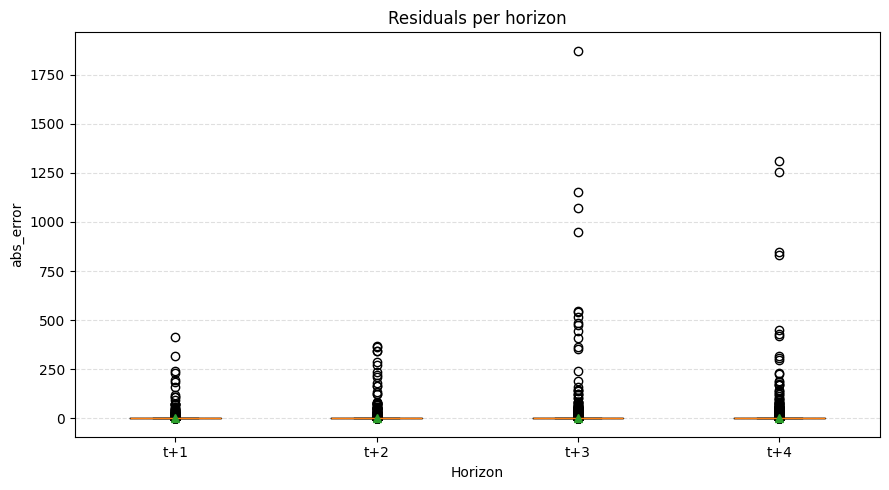

            n      mean    median        std
horizon                                     
t+1      4080  1.234212  0.035070  12.021052
t+2      4172  1.938990  0.065320  15.811270
t+3      4212  4.027677  0.123335  46.613169
t+4      4236  3.694712  0.145306  37.824444


In [149]:
snapshots = outliers["timestamp"].sort_values().unique()
h_map = {ts: f"t+{i+1}" for i, ts in enumerate(snapshots)}

# VARIABLES
dataframe = no_outliers
error = "abs_error"

dataframe["horizon"] = dataframe["timestamp"].map(h_map)

order = [f"t+{i+1}" for i in range(len(snapshots))]

data = [dataframe.loc[dataframe["horizon"] == h, f"{error}"].values for h in order]

plt.figure(figsize=(9, 5))
plt.boxplot(data, showmeans=True)
plt.xticks(range(1, len(order) + 1), order)
plt.title("Residuals per horizon")
plt.xlabel("Horizon")
plt.ylabel(f"{error}")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

resumen = (
    dataframe.groupby("horizon")[f"{error}"]
    .agg(n="count", mean="mean", median="median", std="std")
    .reindex(order)
)
print(resumen)

In [ ]:
errors_por_snapshot = (
    predictions
    .groupby("timestamp")
    .agg(
        mae=("abs_error", "mean"),
        z_mae=("z_abs_error", "mean"),
        n=("abs_error", "size")  # cuántas predicciones entran en el promedio
    )
    .sort_index()
    .reset_index()
)
snapshots_ordenados = errors_por_snapshot["timestamp"].sort_values().unique()

map_h = {ts: f"t+{i+1}" for i, ts in enumerate(snapshots_ordenados)}
errors_por_snapshot["horizon"] = errors_por_snapshot["timestamp"].map(map_h)
errors_por_snapshot

timestamp       mae     z_mae     n horizon
0 2025-07-09  1.716837  0.277782  4289     t+1
1 2025-07-16  2.144166  0.423315  4289     t+2
2 2025-07-23  4.168462  0.666189  4289     t+3
3 2025-07-30  3.682100  0.730292  4289     t+4